# Bayesian Probabilistic Matrix Factorization using MCMC

In [1]:
import pyro
import spotlight
import pandas as pd
import seaborn
from spotlight.cross_validation import random_train_test_split
from spotlight.datasets.movielens import get_movielens_dataset
from spotlight.evaluation import rmse_score
from spotlight.factorization.explicit import ExplicitFactorizationModel
import torch

import numpy as np
import matplotlib.pyplot as plt
d = 5

## Load data

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Total length of dataset 100000
num users: 944, num items: 1683


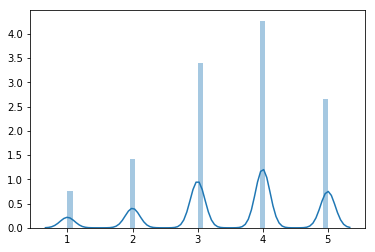

In [2]:
ds = get_movielens_dataset(variant='100K')

items = pd.read_csv("movies.dat", delimiter="::", header=None, engine = "python")
items.columns = ['itemId', 'name','genre']
ind2item = {row.itemId : row.name for row in items.itertuples()}

train, test = random_train_test_split(ds)

_ =seaborn.distplot(ds.ratings)
print(f"Total length of dataset {len(ds.ratings)}")
print(f"num users: {ds.num_users}, num items: {ds.num_items}")

## Explicit Matrix Factorization
Train an explicit model to kickstart the mcmc optimization.
Using spotlight's explicit mf model to do so. The BilinearNet is a modification from the original with no bias.

In [3]:
import torch.nn as nn

from spotlight.layers import ScaledEmbedding, ZeroEmbedding


class BilinearNet(nn.Module):
    """
    Bilinear factorization representation.
    Encodes both users and items as an embedding layer; the score
    for a user-item pair is given by the dot product of the item
    and user latent vectors.
    Parameters
    ----------
    num_users: int
        Number of users in the model.
    num_items: int
        Number of items in the model.
    embedding_dim: int, optional
        Dimensionality of the latent representations.
    user_embedding_layer: an embedding layer, optional
        If supplied, will be used as the user embedding layer
        of the network.
    item_embedding_layer: an embedding layer, optional
        If supplied, will be used as the item embedding layer
        of the network.
    sparse: boolean, optional
        Use sparse gradients.
    """

    def __init__(self, num_users, num_items, embedding_dim=32,
                 user_embedding_layer=None, item_embedding_layer=None, sparse=False):

        super(BilinearNet, self).__init__()

        self.embedding_dim = embedding_dim

        if user_embedding_layer is not None:
            self.user_embeddings = user_embedding_layer
        else:
            self.user_embeddings = ScaledEmbedding(num_users, embedding_dim,
                                                   sparse=sparse)

        if item_embedding_layer is not None:
            self.item_embeddings = item_embedding_layer
        else:
            self.item_embeddings = ScaledEmbedding(num_items, embedding_dim,
                                                   sparse=sparse)

        #self.user_biases = ZeroEmbedding(num_users, 1, sparse=sparse)
        #self.item_biases = ZeroEmbedding(num_items, 1, sparse=sparse)

    def forward(self, user_ids, item_ids):
        """
        Compute the forward pass of the representation.
        Parameters
        ----------
        user_ids: tensor
            Tensor of user indices.
        item_ids: tensor
            Tensor of item indices.
        Returns
        -------
        predictions: tensor
            Tensor of predictions.
        """

        user_embedding = self.user_embeddings(user_ids)
        item_embedding = self.item_embeddings(item_ids)

        user_embedding = user_embedding.squeeze()
        item_embedding = item_embedding.squeeze()

        #user_bias = self.user_biases(user_ids).squeeze()
        #item_bias = self.item_biases(item_ids).squeeze()

        dot = (user_embedding * item_embedding).sum(1)

        return dot #+ user_bias + item_bias

In [4]:
network = BilinearNet(num_users = ds.num_users,
           num_items = ds.num_items,
           embedding_dim = d)

model = ExplicitFactorizationModel(n_iter=1, embedding_dim=d, representation=network)


In [5]:
%%time
for t in range(20):
    model.fit(train)
    rmse_test = rmse_score(model, test)
    rmse_train = rmse_score(model, train)
    print(f'step: {t} \t rmse train: {rmse_train:.2f}, test: {rmse_test:.2f}')

step: 0 	 rmse train: 1.18, test: 1.23
step: 1 	 rmse train: 0.95, test: 1.00
step: 2 	 rmse train: 0.92, test: 0.98
step: 3 	 rmse train: 0.91, test: 0.98
step: 4 	 rmse train: 0.89, test: 0.97
step: 5 	 rmse train: 0.88, test: 0.97
step: 6 	 rmse train: 0.87, test: 0.97
step: 7 	 rmse train: 0.85, test: 0.97
step: 8 	 rmse train: 0.85, test: 0.97
step: 9 	 rmse train: 0.84, test: 0.97
step: 10 	 rmse train: 0.83, test: 0.97
step: 11 	 rmse train: 0.83, test: 0.98
step: 12 	 rmse train: 0.82, test: 0.97
step: 13 	 rmse train: 0.82, test: 0.97
step: 14 	 rmse train: 0.82, test: 0.98
step: 15 	 rmse train: 0.82, test: 0.98
step: 16 	 rmse train: 0.81, test: 0.98
step: 17 	 rmse train: 0.81, test: 0.98
step: 18 	 rmse train: 0.81, test: 0.98
step: 19 	 rmse train: 0.81, test: 0.98
CPU times: user 8.47 s, sys: 125 ms, total: 8.59 s
Wall time: 8.7 s


## Bayesian mf MCMC

In [6]:
import bayesMF
from importlib import reload
reload(bayesMF)

<module 'bayesMF' from '/Users/simeneide/Sync/finn/phd-notes/general_notes/bayesian-mf/bayesMF.py'>

In [7]:
bayesmodel = bayesMF.BayesianMF(train=train, 
                        test = test,
                        num_items=ds.num_items,
                        num_users = ds.num_users,
                        embedding_dim = d)
bayesmodel

BayesianMF()

In [8]:
%%time
bayesmodel.fit(20)

step: 0 	 rmse train: 3.70, test: 3.71
step: 1 	 rmse train: 3.70, test: 3.71
step: 2 	 rmse train: 3.70, test: 3.70
step: 3 	 rmse train: 2.27, test: 2.31
step: 4 	 rmse train: 0.95, test: 0.99
step: 5 	 rmse train: 0.92, test: 0.97
step: 6 	 rmse train: 0.92, test: 0.98
step: 7 	 rmse train: 0.92, test: 0.97
step: 8 	 rmse train: 0.92, test: 0.96
step: 9 	 rmse train: 0.92, test: 0.97
step: 10 	 rmse train: 0.92, test: 0.97
step: 11 	 rmse train: 0.92, test: 0.97
step: 12 	 rmse train: 0.92, test: 0.97
step: 13 	 rmse train: 0.92, test: 0.97
step: 14 	 rmse train: 0.92, test: 0.97
step: 15 	 rmse train: 0.92, test: 0.97
step: 16 	 rmse train: 0.92, test: 0.97
step: 17 	 rmse train: 0.92, test: 0.97
step: 18 	 rmse train: 0.92, test: 0.97
step: 19 	 rmse train: 0.92, test: 0.96
CPU times: user 19 s, sys: 76.8 ms, total: 19 s
Wall time: 19.5 s


(tensor(0.9175), tensor(0.9644))

## Analysis

### Distribution of some random user item combinations

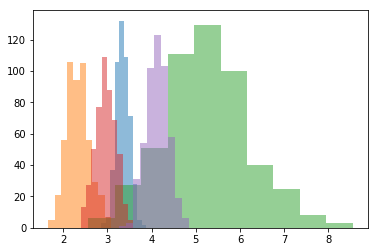

In [9]:
users = np.random.randint(low=0, high=bayesmodel.num_users, size = 5)
items = np.random.randint(0,bayesmodel.num_items, size = 5)
for u,i in zip(users,items):
    score, uvec, ivec = bayesmodel.posterior_score(userId=u, itemId=i)
    _ = plt.hist(score.numpy(), alpha = 0.5)

## Posterior score distribution in user item pairs with with lots of data vs little data
Guess which distribution is from what pair...

least pop item: 442
most pop item: 50
least pop users: 19
most pop users: 405


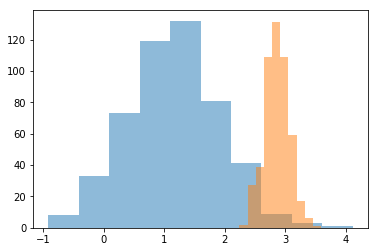

In [10]:
items, counts = np.unique(train.item_ids, return_counts=True)
item_min = items[counts == counts.min()][0]
item_max = items[counts == counts.max()][0]
print("least pop item: {}".format(item_min))
print("most pop item: {}".format(item_max))

users, counts = np.unique(train.user_ids, return_counts=True)
user_min = users[counts == counts.min()][0]
user_max = users[counts == counts.max()][0]
print("least pop users: {}".format(user_min))
print("most pop users: {}".format(user_max))

score, uvec, ivec = bayesmodel.posterior_score(userId=user_min, itemId=item_min)
_ = plt.hist(score.numpy(), alpha = 0.5)

score, uvec, ivec = bayesmodel.posterior_score(userId=user_max, itemId=item_max)
_ = plt.hist(score.numpy(), alpha = 0.5)

#### Posterior vectors from least and most active objects
Plot of posterior user and item vectors for the user item pairs with most and least data (guess which is which).

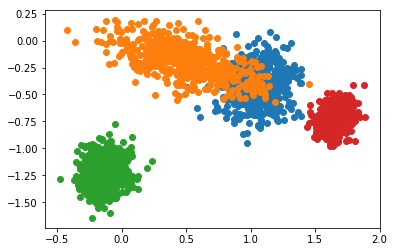

In [11]:
score, uvec, ivec = bayesmodel.posterior_score(userId=user_min, itemId=item_min)
uvec, ivec = uvec.numpy(), ivec.numpy()
_ = plt.plot(uvec[:,0], uvec[:,1], "o")
_ = plt.plot(ivec[:,0], ivec[:,1], "o")
score, uvec, ivec = bayesmodel.posterior_score(userId=user_max, itemId=item_max)
uvec, ivec = uvec.numpy(), ivec.numpy()
_ = plt.plot(uvec[:,0], uvec[:,1], "o")
_ = plt.plot(ivec[:,0], ivec[:,1], "o")

## Variations in topK predictions
Given two different users (the maximum and minimum user), how does their recommendations spread qualitatively?
For each user we sample five different posteriors and fetch top 5 movies for each posterior sample.

In [12]:
u = user_max
for k in range(5):
    bayesmodel.step_mcmc()
    preds = bayesmodel.predict(u,torch.arange(0,bayesmodel.num_items))
    scores, sorts = preds.sort(descending=True)
    print(" \t | ".join([ ind2item[int(i)] for i in sorts[:5]]))

KeyError: 0

In [ ]:
u = user_min
for k in range(5):
    bayesmodel.step_mcmc()
    preds = bayesmodel.predict(u,torch.arange(0,bayesmodel.num_items))
    scores, sorts = preds.sort(descending=True)
    print(" \t | ".join([ ind2item[int(i)] for i in sorts[:5]]))